In [1]:
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt

This notebook to study the behaviour of joint probability in a bayesian network with binary variables under a constraint of monotonicity for all CPTs.

Let $x=(x_1,\cdots,x_n)$ and $y=(y_1,\cdots,y_n)$ 2 instanciations of $n$ binary variables ($x$ et $y$ $\in \{0,1\}^n$), we say that 
<h2>
<center>
    $x \subseteq y \iff [ x_i=1 \Rightarrow y_i=1 ]$
</center>
</h2>


We then define a monotonic CPT $P(A|B)$ by
<h2>
    <center>
        $\forall b \subseteq b', P(A=1|b) < P(A=1|b')$
    </center>
</h2>

In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

# Generation of monotonic CPTs

In [3]:
def monotoneCPT(bn,node,w):
    """
    Create a monotonic CPT using the weight w for node in the bn.
    w is a list of weight for each parent of node.
    if node has n parents, w has a size n+2 : w[0] and w[n+1] control if how far the proba are from 0 and 1.
    Particularly, if w[0]=w[n+1]=0, then 0 and 1 are reached.
    """
    norm=1.0*sum(w)
    p=bn.cpt(node)
    idx=gum.Instantiation(p)
    idx.setFirst()
    while not idx.end():
        v=1.0*w[0]
        for i in range(1,p.nbrDim()):
            if idx.val(i)==1:
                v+=w[i]
        v=v/norm
        idx.chgVal(0,0)
        p.set(idx,1-v)
        idx.chgVal(0,1)
        p.set(idx,v)
        idx.incNotVar(idx.variable(0))
    
def general_mCPT(bn,node,with_zero=True,with_one=True):
    """
    create a general monotonic CPT with or without 0 and 1 for the extreme case
    """
    siz=bn.cpt(node).nbrDim() 
    if siz==1:
        r=rand()
        bn.cpt(node)[:]=(r,1-r)
    else:
        while True:
            w=rand(siz+1) # n+2 rand if n is the number of parents
            
            if with_zero:
                w[0]=0.0
            else:
                if w[0]==0.0:
                    w[0]=1.0
                    
            if with_one:
                w[siz]=0.0
            else:
                if w[siz]==0.0:
                    w[siz]=1.0
                    
            if sum(w)>0:
                break
    
        monotoneCPT(bn,node,w)
        
def at_least_half_mCPT(bn,node,with_zero=True,with_one=True):
    """
    create a general monotonic CPT beginning with 0.5 and with or without 1 for the extreme case
    """
    siz=bn.cpt(node).nbrDim() 
    if siz==1:
        r=rand()
        if r<0.5:
            bn.cpt(node)[:]=(r,1-r)
        else:
            bn.cpt(node)[:]=(1-r,r)
    else:
        while True:
            w=rand(siz+1) # n+2 rand if n is the number of parents
            w[0]=sum(w)
            if with_one:
                w[siz]=0.0
            if sum(w)>0:
                break
                
        monotoneCPT(bn,node,w)
    
def checkMonotonicityNode(bn,node):
    """
    checks if the cpt of node is monotonic
    """
    p=bn.cpt(node)
    idx=gum.Instantiation(p)
    idx.setFirst()
    idx.chgVal(0,1)
    while not idx.end():
        pp=p.get(idx)
        zero_in_idx=gum.Instantiation()
        for k in range(1,p.nbrDim()):
            if idx.val(k)==0:
                zero_in_idx.add(idx.variable(k))
        
        ref=str(idx)
        idx.incIn(zero_in_idx)
        while not idx.end():
            pp2=p.get(idx)
            if pp2<pp:
                print ("error %s:%f<%s:%f"%(str(idx),pp2,ref,pp))
                return False
            idx.incIn(zero_in_idx)
            
        idx.setFirstIn(zero_in_idx)
        idx.incNotVar(p.variable(0))
        
    return True

def checkMonotonicity(bn):
    """
    check if every nodes are monotonic in the bn
    """
    for node in bn.ids():
        if not checkMonotonicityNode(bn,node):
            print(bn.cpt(node))
            return False
    return True


In [4]:
import pydotplus as dot
import IPython.display

def compact(idx):
    """
    compact version of instantiation as string
    """
    s=""
    for i in range(idx.nbrDim()):
        s+=str(idx.val(i))
    return s

def showMonotonicity(bn,node,size="6"):
    """
    create a representation of the monotonicity of a cpt as a lattice of increasing probabilities
    """
    p=bn.cpt(node)
    idx=gum.Instantiation(p)
    idx.setFirst()
    idx.chgVal(0,1)
    
    graph=dot.Dot(graph_type='digraph')
    nodes={}
    
    while not idx.end():
        name="%f (%s)"%(p.get(idx),compact(idx))
        node=dot.Node(name,style="filled")
        nodes[compact(idx)]=node
        graph.add_node(node)
        
        for i in range(1,idx.nbrDim()):
            if idx.val(i)==1:
                idx.chgVal(i,0)
                edge=dot.Edge(nodes[compact(idx)],node)
                graph.add_edge(edge)
                idx.chgVal(i,1)
                
        idx.incNotVar(p.variable(0))
    
    res=IPython.display.SVG(graph.create_svg())
    return res

In [5]:
g=gum.BNGenerator()
bn=g.generate(8,11,2) # 8 nodes, 14 arcs, binary variables  
gnb.showBN(bn,size="10") 


Showing the lattice of certain CPTs in order to check their monotonicity

In [6]:
s1="error"
s2="error"
for node in bn.ids():
    general_mCPT(bn,node,False,False)
if checkMonotonicity(bn):
    node_max=max([(len(bn.parents(i)),i) for i in bn.ids()])
    s1="bn is really monotonic (generic version). For instance %s"%bn.variable(node_max[1]).name()
    r1=showMonotonicity(bn,node_max[1])

for node in bn.ids():
    at_least_half_mCPT(bn,node,False,False)
if checkMonotonicity(bn):
    node_max=max([(len(bn.parents(i)),i) for i in bn.ids()])
    s2="bn is really monotonic (with p>0.5). For instance %s"%bn.variable(node_max[1]).name()
    r2=showMonotonicity(bn,node_max[1])
    
IPython.display.HTML("<table><tr><td>"+r1.data+"</td><td>"+r2.data+"</td></tr><tr><td>"+s1+"</td><td>"+s2+"</td></tr></table>")

bn is really monotonic (generic version). For instance n_4,bn is really monotonic (with p>0.5). For instance n_4


# Plotting of $\log_2 P_{BN}(x_1,\cdots,x_n), \forall (x_1,\cdots,x_n) \in \{0,1\}^n$

In [7]:
def ll(bn,i):
    #return bn.jointProbability(i)
    return bn.log2JointProbability(i)
    
def BigSmile(bn,ax):
    i=gum.Instantiation()
    bn.completeInstantiation(i)
    
    x=list()
    y=list()
    #i.setFirst()
    #print("first : %f"%ll(bn,i))
    #i.setLast()
    #print("last : %f"%ll(bn,i))
    i.setFirst()
    
    iter=0
    jmax=ll(bn,i)
    jmin=ll(bn,i)
    maxl=[str(i)]
    while not i.end():
        j=ll(bn,i)
        if jmax<j:
            maxl=[str(i)]
            jmax=j
        elif jmax==j:
            maxl.append(str(i))
        if jmin>j:
            jmin=j
        
        x.append(i.hamming())
        y.append(j)
        
        i.inc()
        iter+=1
        
    #print("max :%f, #ite:%d "%(jmax,iter))
    
    ax.set_xlim([-0.5,bn.size()+0.5])
    v=0.1*(jmax-jmin)
    ax.set_ylim([jmin-v,jmax+v])
    ax.plot(x,y,marker="+",linestyle='')


# $3 \times 3$ tests for a monotonic generator

In [8]:
rcParams['figure.figsize'] = 16, 16

def MonotonyStudy(bn,monotoneMethod,title):
    wx=3
    wy=3
    f,axs=plt.subplots(wx,wy,sharex=True,sharey=False)
    f.subplots_adjust(hspace=0)    
    for i in range(wx):
        for j in range(wy):
            for node in bn.ids():
                monotoneMethod(bn,node,False,False)
            BigSmile(bn,axs[i][j])
    f.text(.5, .92,title,horizontalalignment='center')
  


# For a small BN

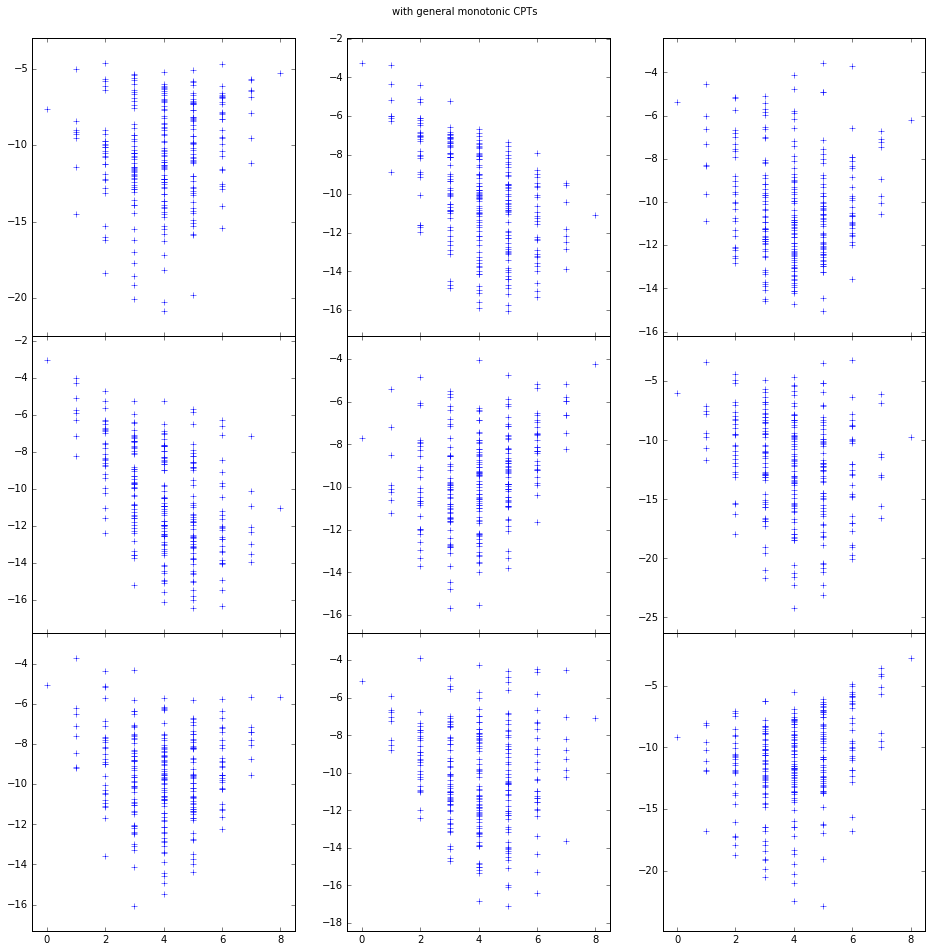

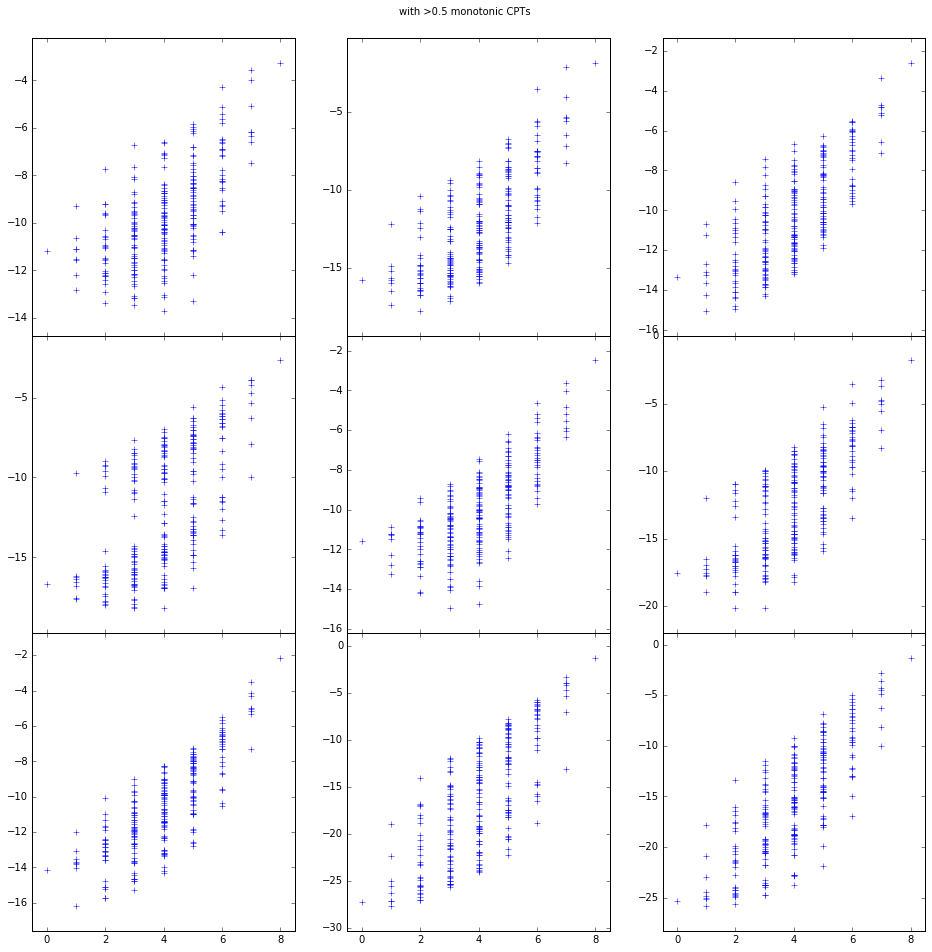

In [9]:
bn=g.generate(8,14,2) # 8 nodes, 14 arcs, binary variables  
gnb.showBN(bn,size="10")
MonotonyStudy(bn,general_mCPT,"with general monotonic CPTs")
MonotonyStudy(bn,at_least_half_mCPT,"with >0.5 monotonic CPTs")

# For a larger one

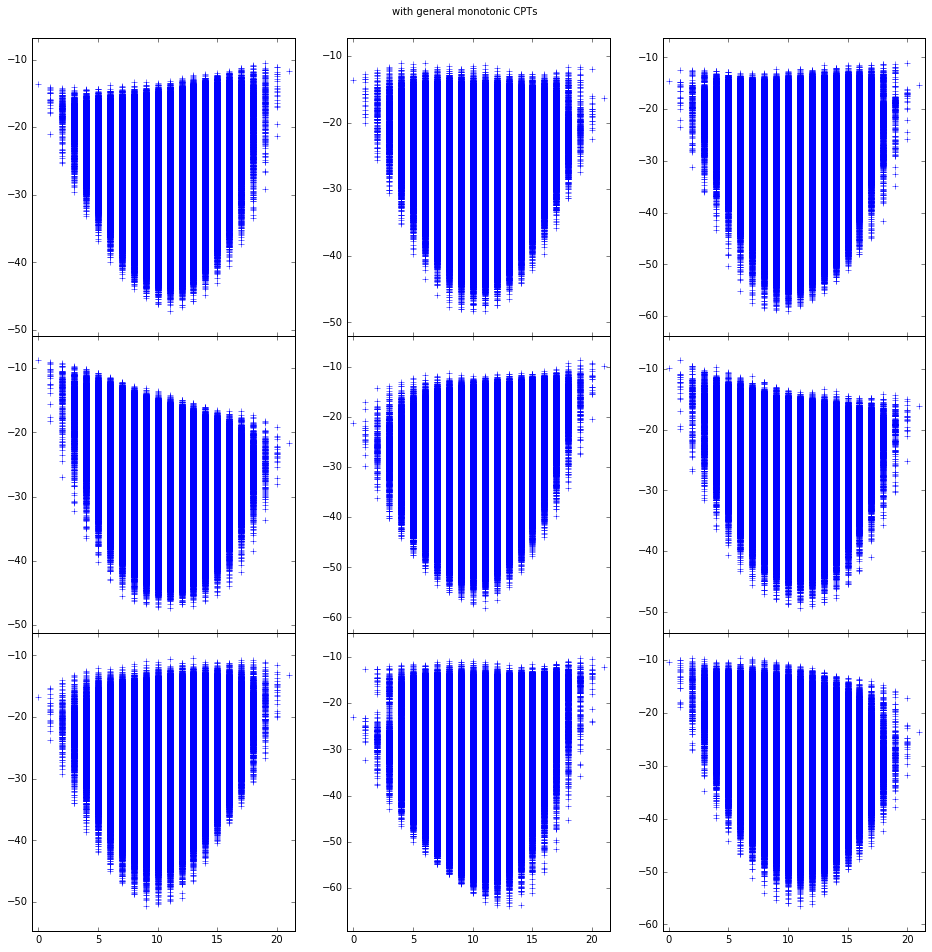

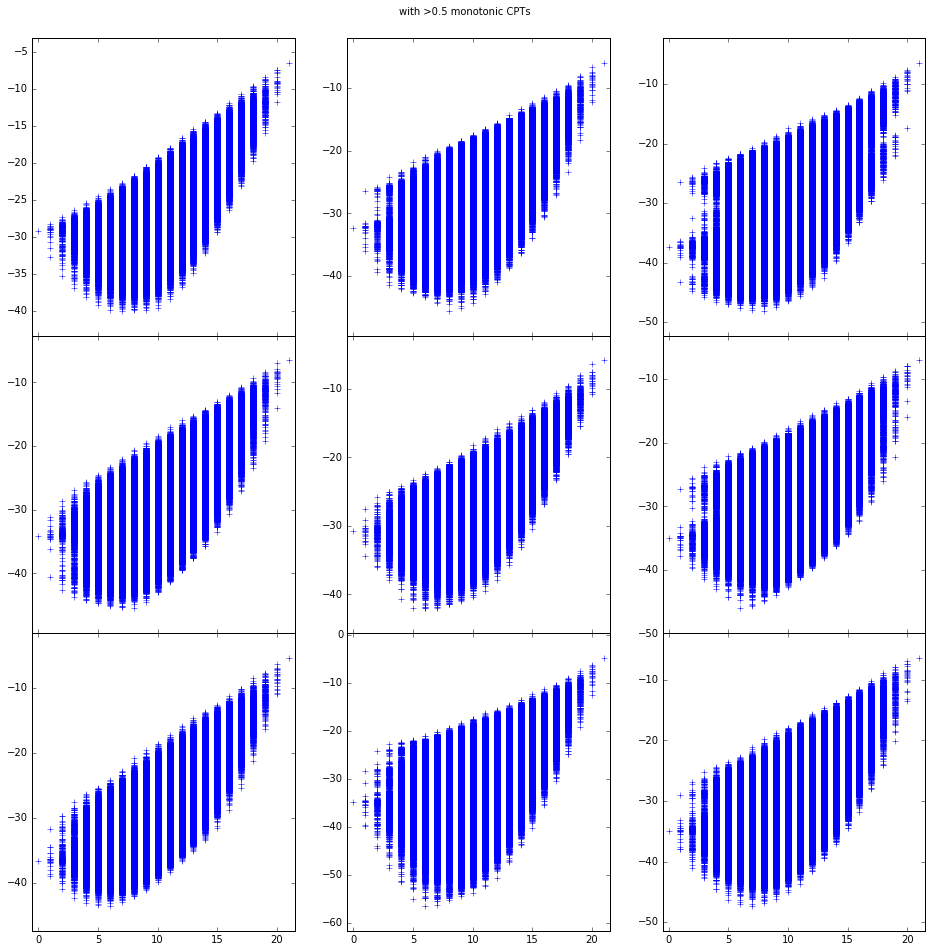

In [10]:
bn=g.generate(21,35,2)  # 21 nodes, 35 arcs, binary variables    
gnb.showBN(bn,size="10")   
MonotonyStudy(bn,general_mCPT,"with general monotonic CPTs")
MonotonyStudy(bn,at_least_half_mCPT,"with >0.5 monotonic CPTs")

# And another one but more dense

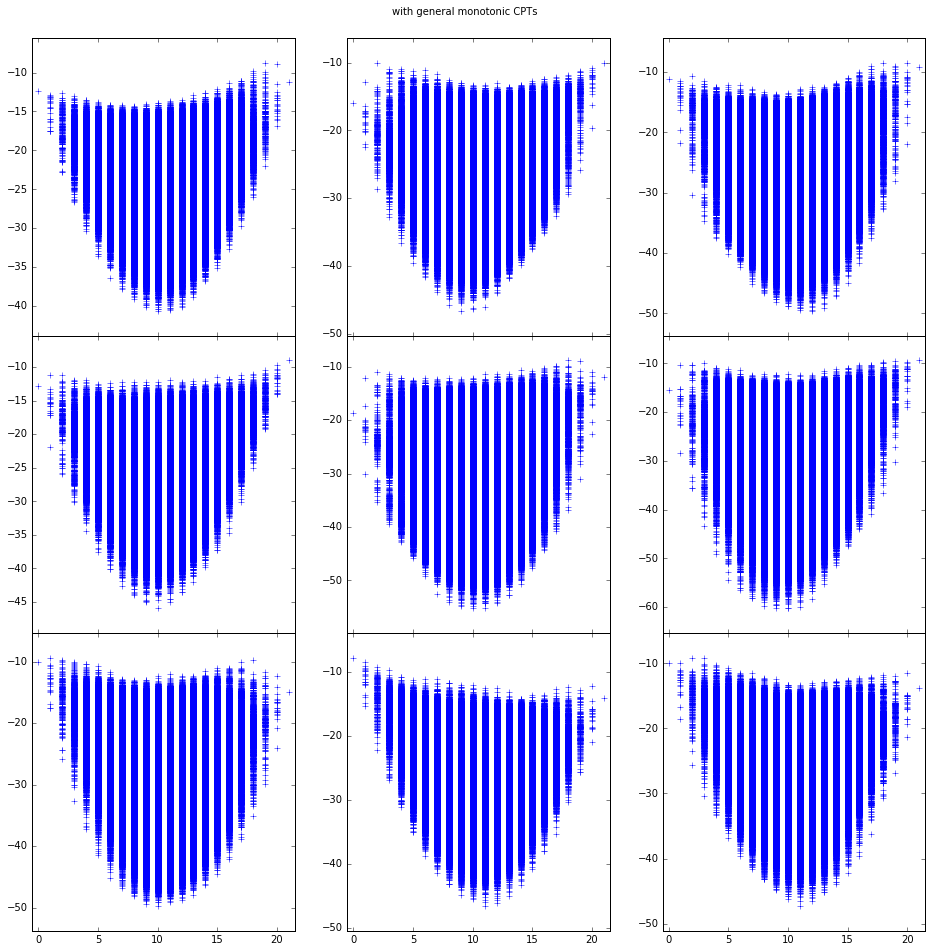

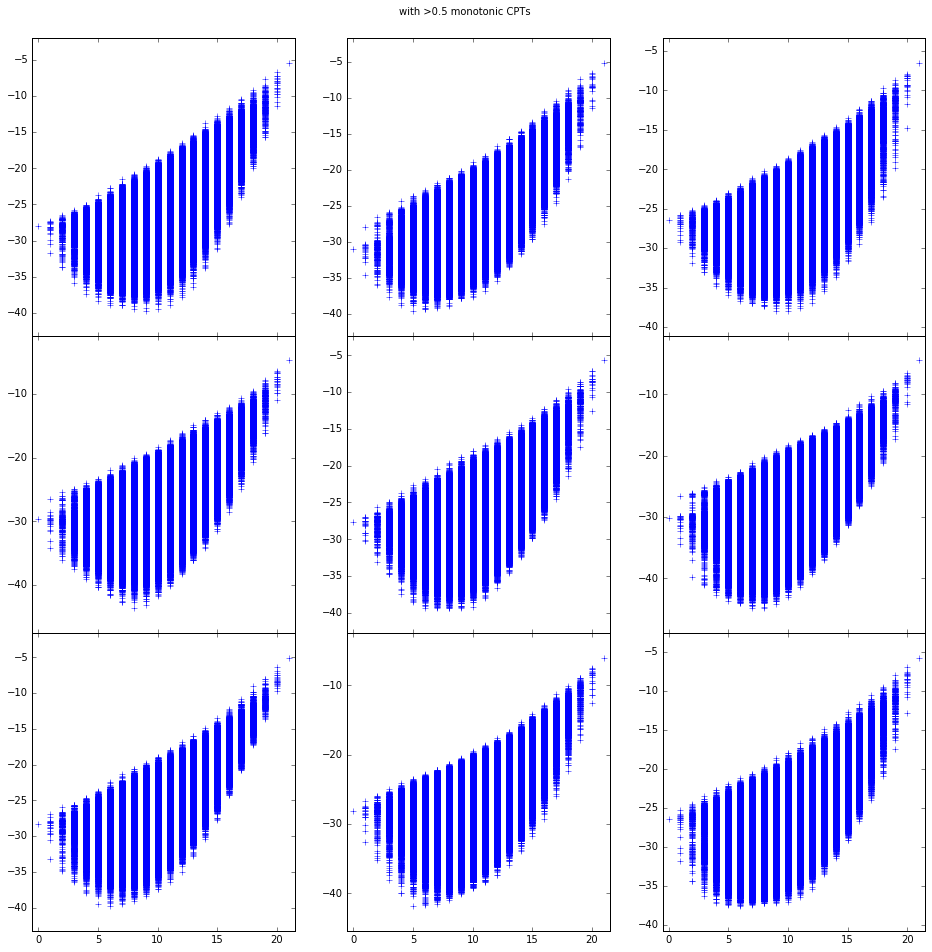

In [11]:
bn=g.generate(21,50,2)     
gnb.showBN(bn,size="10") 
MonotonyStudy(bn,general_mCPT,"with general monotonic CPTs")
MonotonyStudy(bn,at_least_half_mCPT,"with >0.5 monotonic CPTs")